In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import random
import numpy as np
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50
from PIL import Image

In [2]:
DIR_TRAIN = "data/train/"
DIR_VAL = "data/val/"

In [3]:
class DeepFakeDataset(Dataset):
    def __init__(self, imgs, mode = "train", transforms = None):
        super().__init__()
        self.imgs = imgs
        self.mode = mode
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_name = self.imgs[idx]
        label = 0
        if ("original" in image_name): label = 1
        label = torch.tensor(label, dtype = torch.float32)
        
        # Training
        if self.mode == "train":
            img = Image.open(image_name).resize((224, 224))
            img = self.transforms(img)
            return img, label
                
        # Validation
        elif self.mode == "val":
            img = Image.open(image_name).resize((224, 224))
            img = self.transforms(img)
            return img, label
        
        # Training
        elif self.mode == "train":
            img = Image.open(image_name).resize((224, 224))
            img = self.transforms(img)
            return img, label
    
    def __len__(self):
        return len(self.imgs)

In [4]:
def make_dataloader(data_path):
    original_imgs = glob.glob(f"{data_path}/original/*")
    fake_imgs = glob.glob(f"{data_path}/manipulated/*")
    original_imgs.extend(fake_imgs)
    imgs = original_imgs
    transforms = T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0), (1, 1, 1))
    ])
    if ("train" in data_path) :
        tranforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(15),
            T.RandomCrop(204),
            T.ToTensor(),
            T.Normalize((0, 0, 0),(1, 1, 1))
        ])
    else :
        transforms = T.Compose([
            T.ToTensor(),
            T.Normalize((0, 0, 0), (1, 1, 1))
        ])  
    
    mode = "train"
    if "val" in data_path: mode = "val"
    elif "test" in data_path: mode = "test"
    
    dataset = DeepFakeDataset(imgs, mode=mode, transforms=transforms)    
    dataloader = DataLoader(dataset = dataset, batch_size = 32, shuffle = True)
    return dataloader

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [6]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [7]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [8]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"main.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [9]:
model = resnet50(pretrained = True)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [10]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [11]:
best_val_acc = 0
train_dataloader = make_dataloader(DIR_TRAIN)
val_dataloader = make_dataloader(DIR_VAL)
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_dataloader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_dataloader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    


Training
Epoch 1
Loss : 0.4235
Acc : 77.9699
Time : 118.0447

Validating
Epoch 1
Loss : 0.2637
Acc : 89.2509
Time : 18.1033

Training
Epoch 2
Loss : 0.1928
Acc : 92.0102
Time : 115.7686

Validating
Epoch 2
Loss : 0.2465
Acc : 90.2039
Time : 18.2733

Training
Epoch 3
Loss : 0.108
Acc : 95.8112
Time : 117.1568

Validating
Epoch 3
Loss : 0.2493
Acc : 89.8493
Time : 18.0598

Training
Epoch 4
Loss : 0.0792
Acc : 96.9637
Time : 116.0881

Validating
Epoch 4
Loss : 0.2035
Acc : 92.4645
Time : 18.3372

Training
Epoch 5
Loss : 0.0501
Acc : 98.3267
Time : 116.1502

Validating
Epoch 5
Loss : 0.1816
Acc : 93.75
Time : 17.9582

Training
Epoch 6
Loss : 0.0491
Acc : 98.5372
Time : 115.6034

Validating
Epoch 6
Loss : 0.204
Acc : 93.3954
Time : 17.9945

Training
Epoch 7
Loss : 0.0341
Acc : 98.8918
Time : 116.7561

Validating
Epoch 7
Loss : 0.1619
Acc : 95.3901
Time : 17.9238

Training
Epoch 8
Loss : 0.0273
Acc : 99.2021
Time : 115.6204

Validating
Epoch 8
Loss : 0.1963
Acc : 94.8582
Time : 18.5405

Tra

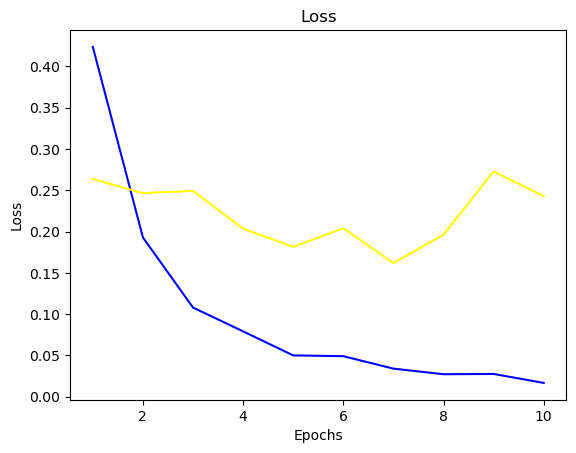

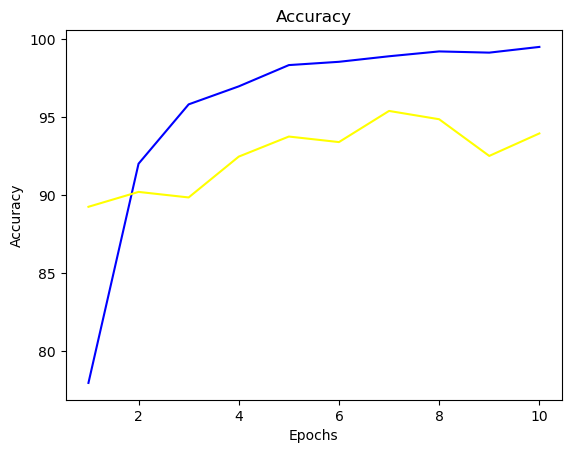

In [12]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()